<a href="https://colab.research.google.com/github/xcarslan/cerenonetelent23/blob/main/VGG16_Ag%C4%B1rl%C4%B1kl%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Data paths
train_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Train'
validation_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Validation'
test_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Test'

# Parameters
img_width, img_height = 224, 224  # VGG16 için varsayılan giriş boyutu
num_classes = 4
learning_rate = 0.0001
vgg16_epochs = [15,30,45]
batch_sizes = [32,64]

# Create the output folder
output_folder = '/content/drive/MyDrive/Proje Tasarımı/'
os.makedirs(output_folder, exist_ok=True)

# Iterate over batch sizes
for batch_size in batch_sizes:
    # Iterate over epochs
    for epoch in vgg16_epochs:
        # Create VGG16 model
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

        # Freeze the layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom classification head
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Data augmentation configuration
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            rescale=1./255
        )

        test_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            rescale=1./255
        )

        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='categorical')

        validation_generator = test_datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='categorical')

        # Create a folder for each combination
        combination_folder = os.path.join(output_folder, f'lr_{learning_rate}_bs_{batch_size}_epochs_{epoch}_vgg16')
        os.makedirs(combination_folder, exist_ok=True)


        # ModelCheckpoint callback'i kullanarak en iyi modeli kaydetme
        checkpoint_filepath = os.path.join(combination_folder, 'best_model.h5')
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=False,  # Tam modeli kaydet
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

        # Modeli eğit
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=epoch,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=[model_checkpoint_callback]  # ModelCheckpoint'i ekleyin
        )

        # Belirli epoch değerlerindeki ağırlıkları kaydet
        for specific_epoch in [15, 30, 45]:
            if specific_epoch <= epoch:
                model_weights_filepath = os.path.join(combination_folder, f'model_weights_epoch_{specific_epoch}_bs_{batch_size}.h5')
                model.save_weights(model_weights_filepath)

        # Eğitim geçmişini dosyaya kaydet
        history_filepath = os.path.join(combination_folder, f'training_history_bs_{batch_size}.json')
        with open(history_filepath, 'w') as file:
            json.dump(history.history, file)

Found 3600 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Epoch 1/15
112/112 [==============================] - ETA: 0s - loss: 1.2833 - accuracy: 0.4496 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 1838s 16s/step - loss: 1.2833 - accuracy: 0.4496 - val_loss: 1.1720 - val_accuracy: 0.5988
Epoch 2/15
112/112 [==============================] - 62s 557ms/step - loss: 1.0903 - accuracy: 0.5869 - val_loss: 1.0249 - val_accuracy: 0.5904
Epoch 3/15
112/112 [==============================] - 63s 561ms/step - loss: 0.9693 - accuracy: 0.5925 - val_loss: 0.9136 - val_accuracy: 0.6216
Epoch 4/15
112/112 [==============================] - 62s 557ms/step - loss: 0.8870 - accuracy: 0.6177 - val_loss: 0.8437 - val_accuracy: 0.6182
Epoch 5/15
112/112 [==============================] - 63s 564ms/step - loss: 0.8291 - accuracy: 0.6455 - val_loss: 0.8009 - val_accuracy: 0.6326
Epoch 6/15
112/112 [==============================] - 63s 563ms/step - loss: 0.7882 - accuracy: 0.6376 - val_loss: 0.7713 - val_accuracy: 0.6402
Epoch 7/15
112/112 [==============================] - 64s 567ms/step - loss: 0.7553 - accuracy: 0.6592 - val_loss: 0.7324 - val_accuracy: 0.6

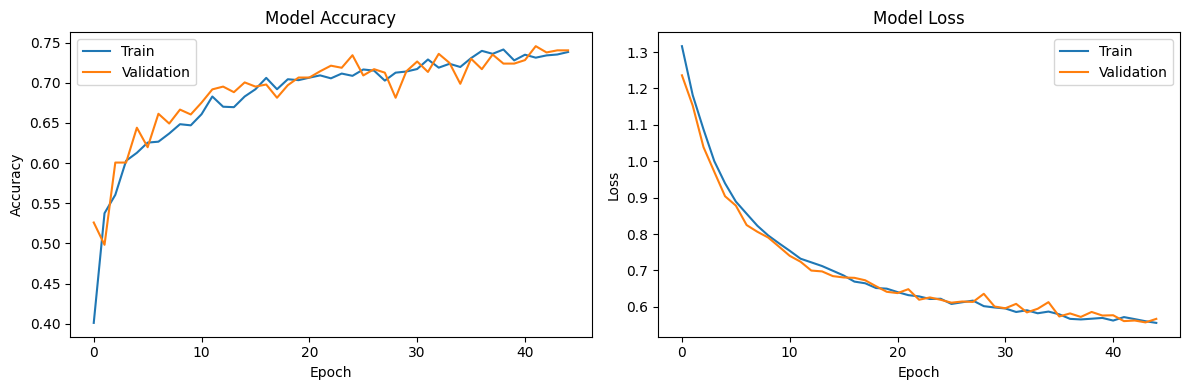

2/2 [==============================] - 0s 114ms/step


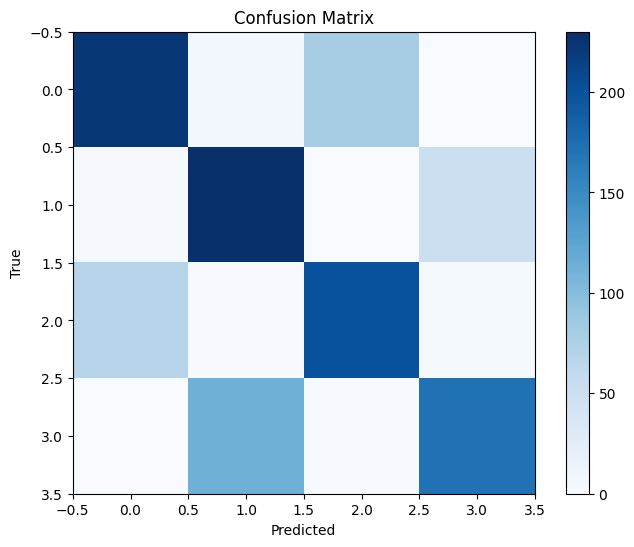

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74       309
           1       0.66      0.82      0.73       282
           2       0.71      0.73      0.72       275
           3       0.76      0.60      0.67       286

    accuracy                           0.72      1152
   macro avg       0.72      0.72      0.72      1152
weighted avg       0.72      0.72      0.72      1152



In [ ]:
from sklearn.metrics import classification_report

# Load the best model
best_model_path = os.path.join(combination_folder, 'best_model.h5')
best_model = tf.keras.models.load_model(best_model_path)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
y_true = []
y_pred = []

# Predict on validation data
for i in range(validation_generator.samples // batch_size):
    images, labels = validation_generator.next()
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot to integer
    predictions = best_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert one-hot to integer

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_labels = [str(i) for i in range(num_classes)]
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Data paths
train_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Train'
validation_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Validation'
test_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Test'

# Parameters
# Parameters
img_width, img_height = 224, 224  # VGG16 için varsayılan giriş boyutu
num_classes = 4
learning_rate = 0.0001
vgg16_epochs = [15,30,45]
batch_sizes = [32,64]

# Create the output folder
output_folder = '/content/drive/MyDrive/Proje Tasarımı/'
os.makedirs(output_folder, exist_ok=True)

# Iterate over batch sizes
for batch_size in batch_sizes:
    # Iterate over epochs
    for epoch in vgg16_epochs:
        # Create VGG16 model
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

        # Freeze the layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom classification head
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Data augmentation configuration
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            rescale=1./255
        )

        test_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            rescale=1./255
        )

        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='categorical')

        validation_generator = test_datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='categorical')


        # Create a folder for each combination
        combination_folder = os.path.join(output_folder, f'lr_{learning_rate}_bs_{batch_size}_epochs_{epoch}_vgg16')
        os.makedirs(combination_folder, exist_ok=True)


        # ModelCheckpoint callback'i kullanarak en iyi modeli kaydetme
        checkpoint_filepath = os.path.join(combination_folder, 'best_model.h5')
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=False,  # Tam modeli kaydet
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

        # Modeli eğit
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=epoch,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=[model_checkpoint_callback]  # ModelCheckpoint'i ekleyin
        )

        # Belirli epoch değerlerindeki ağırlıkları kaydet
        for specific_epoch in [15, 30, 45]:
            if specific_epoch <= epoch:
                model_weights_filepath = os.path.join(combination_folder, f'model_weights_epoch_{specific_epoch}_bs_{batch_size}.h5')
                model.save_weights(model_weights_filepath)

        # Eğitim geçmişini dosyaya kaydet
        history_filepath = os.path.join(combination_folder, f'training_history_bs_{batch_size}.json')
        with open(history_filepath, 'w') as file:
            json.dump(history.history, file)

Found 3600 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Epoch 1/15
112/112 [==============================] - ETA: 0s - loss: 1.3870 - accuracy: 0.2887

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 62s 545ms/step - loss: 1.3870 - accuracy: 0.2887 - val_loss: 1.3871 - val_accuracy: 0.3378
Epoch 2/15
112/112 [==============================] - 60s 537ms/step - loss: 1.3801 - accuracy: 0.3588 - val_loss: 1.3798 - val_accuracy: 0.3708
Epoch 3/15
112/112 [==============================] - 59s 528ms/step - loss: 1.3756 - accuracy: 0.3789 - val_loss: 1.3772 - val_accuracy: 0.3581
Epoch 4/15
112/112 [==============================] - 59s 527ms/step - loss: 1.3734 - accuracy: 0.3618 - val_loss: 1.3742 - val_accuracy: 0.3598
Epoch 5/15
112/112 [==============================] - 59s 525ms/step - loss: 1.3717 - accuracy: 0.3700 - val_loss: 1.3721 - val_accuracy: 0.3505
Epoch 6/15
112/112 [==============================] - 61s 549ms/step - loss: 1.3706 - accuracy: 0.3587 - val_loss: 1.3698 - val_accuracy: 0.3758
Epoch 7/15
112/112 [==============================] - 60s 537ms/step - loss: 1.3687 - accuracy: 0.3688 - val_loss: 1.3691 - val_accuracy: 0.3

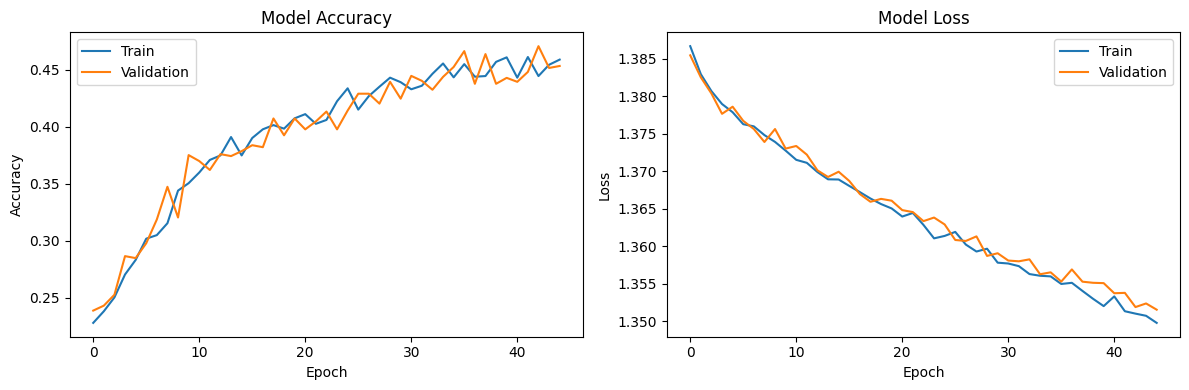

2/2 [==============================] - 0s 111ms/step


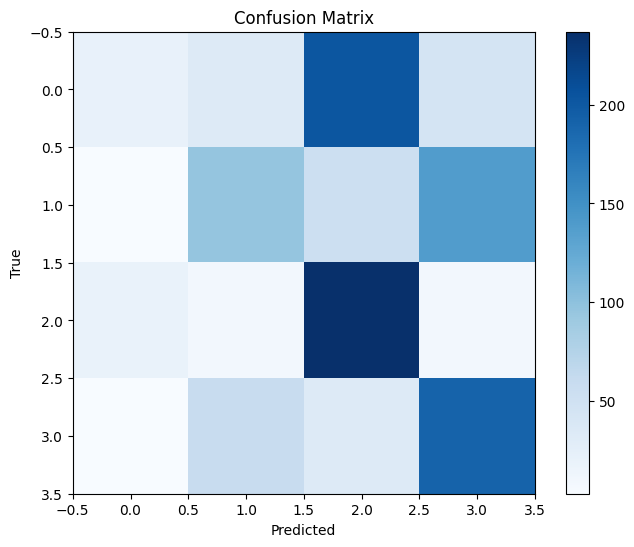

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.07      0.12       302
           1       0.49      0.33      0.39       291
           2       0.45      0.86      0.59       274
           3       0.50      0.67      0.57       285

    accuracy                           0.47      1152
   macro avg       0.47      0.48      0.42      1152
weighted avg       0.47      0.47      0.41      1152



In [ ]:
from sklearn.metrics import classification_report

# Load the best model
best_model_path = os.path.join(combination_folder, 'best_model.h5')
best_model = tf.keras.models.load_model(best_model_path)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
y_true = []
y_pred = []

# Predict on validation data
for i in range(validation_generator.samples // batch_size):
    images, labels = validation_generator.next()
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot to integer
    predictions = best_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert one-hot to integer

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_labels = [str(i) for i in range(num_classes)]
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)


In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Data paths
train_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Train'
validation_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Validation'
test_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Test'


# Parameters
img_width, img_height = 224, 224  # VGG16 için varsayılan giriş boyutu
num_classes = 4
learning_rate = 0.0001
vgg16_epochs = [15,30,45]
batch_sizes = [32,64]

# Create the output folder
output_folder = '/content/drive/MyDrive/Proje Tasarımı/'
os.makedirs(output_folder, exist_ok=True)

# Iterate over batch sizes
for batch_size in batch_sizes:
    # Iterate over epochs
    for epoch in vgg16_epochs:
        # Create VGG16 model
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

        # Freeze the layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom classification head
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Data augmentation configuration
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            rescale=1./255
        )

        test_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            rescale=1./255
        )

        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='categorical')

        validation_generator = test_datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='categorical')


        # Create a folder for each combination
        combination_folder = os.path.join(output_folder, f'lr_{learning_rate}_bs_{batch_size}_epochs_{epoch}_vgg16')
        os.makedirs(combination_folder, exist_ok=True)


        # ModelCheckpoint callback'i kullanarak en iyi modeli kaydetme
        checkpoint_filepath = os.path.join(combination_folder, 'best_model.h5')
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=False,  # Tam modeli kaydet
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

        # Modeli eğit
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=epoch,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=[model_checkpoint_callback]  # ModelCheckpoint'i ekleyin
        )

        # Belirli epoch değerlerindeki ağırlıkları kaydet
        for specific_epoch in [15, 30, 45]:
            if specific_epoch <= epoch:
                model_weights_filepath = os.path.join(combination_folder, f'model_weights_epoch_{specific_epoch}_bs_{batch_size}.h5')
                model.save_weights(model_weights_filepath)

        # Eğitim geçmişini dosyaya kaydet
        history_filepath = os.path.join(combination_folder, f'training_history_bs_{batch_size}.json')
        with open(history_filepath, 'w') as file:
            json.dump(history.history, file)

58889256/58889256 [==============================] - 0s 0us/step
Found 3600 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Epoch 1/15
112/112 [==============================] - ETA: 0s - loss: 1.2794 - accuracy: 0.4397

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 1000s 9s/step - loss: 1.2794 - accuracy: 0.4397 - val_loss: 1.1890 - val_accuracy: 0.4975
Epoch 2/15
112/112 [==============================] - 56s 503ms/step - loss: 1.1082 - accuracy: 0.5524 - val_loss: 1.0516 - val_accuracy: 0.5448
Epoch 3/15
112/112 [==============================] - 57s 507ms/step - loss: 0.9966 - accuracy: 0.5830 - val_loss: 0.9504 - val_accuracy: 0.5887
Epoch 4/15
112/112 [==============================] - 57s 507ms/step - loss: 0.9158 - accuracy: 0.5992 - val_loss: 0.8714 - val_accuracy: 0.6461
Epoch 5/15
112/112 [==============================] - 57s 505ms/step - loss: 0.8615 - accuracy: 0.6172 - val_loss: 0.8205 - val_accuracy: 0.6630
Epoch 6/15
112/112 [==============================] - 55s 489ms/step - loss: 0.8165 - accuracy: 0.6242 - val_loss: 0.8057 - val_accuracy: 0.6225
Epoch 7/15
112/112 [==============================] - 55s 494ms/step - loss: 0.7848 - accuracy: 0.6452 - val_loss: 0.7556 - val_accuracy: 0.66

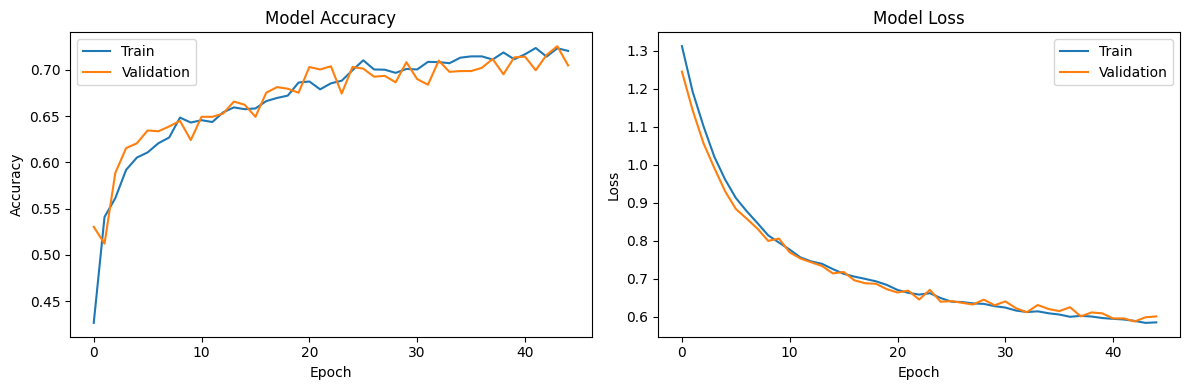

2/2 [==============================] - 0s 111ms/step


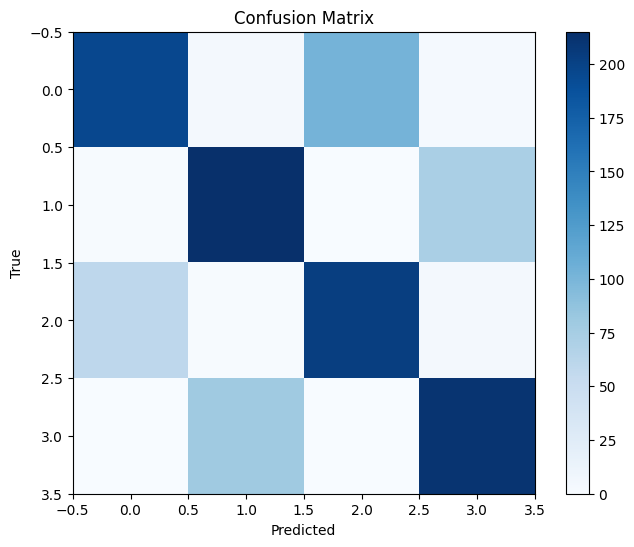

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.64      0.70       305
           1       0.72      0.74      0.73       289
           2       0.67      0.76      0.71       268
           3       0.72      0.73      0.73       290

    accuracy                           0.72      1152
   macro avg       0.72      0.72      0.72      1152
weighted avg       0.72      0.72      0.71      1152



In [2]:
from sklearn.metrics import classification_report

# Load the best model
best_model_path = os.path.join(combination_folder, 'best_model.h5')
best_model = tf.keras.models.load_model(best_model_path)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
y_true = []
y_pred = []

# Predict on validation data
for i in range(validation_generator.samples // batch_size):
    images, labels = validation_generator.next()
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot to integer
    predictions = best_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert one-hot to integer

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_labels = [str(i) for i in range(num_classes)]
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)